In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
assert tf.__version__ >= "2.0"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 10.1.3 퍼셉트론

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2,3)] #꽃잎의 길이와 너비
y = (iris.target == 0).astype(np.int) #부채붓꽃(Iris Setosa) 인가?

per_clf = Perceptron(max_iter = 1000, tol=1e-3, random_state=42)
per_clf.fit(X,y)

y_pred = per_clf.predict([[2,0.5]])

C:\Users\user0216\AppData\Local\Temp\ipykernel_13044\3177393623.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris.target == 0).astype(np.int) #부채붓꽃(Iris Setosa) 인가?


In [3]:
y_pred

array([1])

퍼셉트론 학습 알고리즘이 확률적 경사 하강법과 매우 닮았다고 느꼈을 것이다. \
사실 사이킷런의 Perceptron 클래스는 매개변수가 loss="perceptron", learning_rate="constant", eta0=1(학습률), penalty=None(규제 없음)인 SGDClassifier와 같습니다.

### 10.1.4 다층 퍼셉트론과 역전파
활성화 함수

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

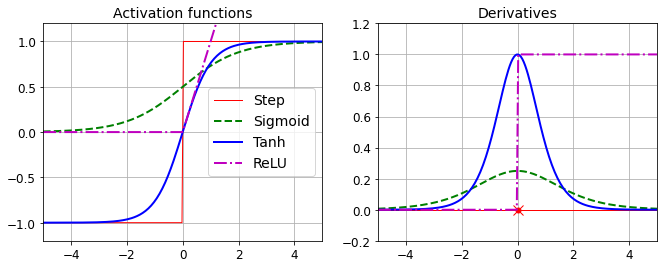

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

In [6]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

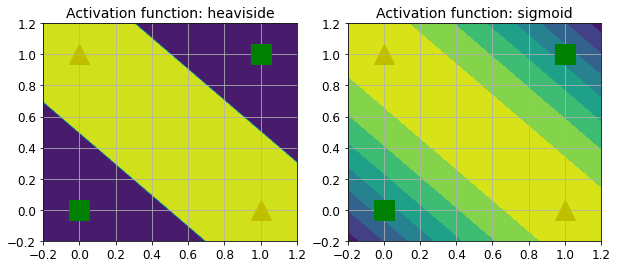

In [7]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

## 10.2 케라스로 다층 퍼셉트론 구현하기

In [8]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.8.0'

In [9]:
keras.__version__

'2.8.0'

### 10.2.2 시퀀셜 API를 사용하여 이미지 분류기 만들기
케라스를 사용하여 데이터셋 적재하기

In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [11]:
X_train_full.shape

(60000, 28, 28)

In [12]:
X_train_full.dtype

dtype('uint8')

전체 훈련 세트를 검증 세트와 조금 더 작은 훈련 세트로 나누겠습니다. 또한 픽셀 강도를 255로 나누어 0~1 범위의 실수로 바꾸겠습니다.

In [13]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000] , y_train_full[5000:]
X_test = X_test / 255.0

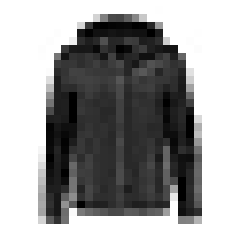

In [14]:
plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

In [15]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [16]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
             "Sandal","Shrit", "Sneaker", "Bag", "Ankel boot"]

In [17]:
class_names[y_train[0]]

'Coat'

In [18]:
X_valid.shape

(5000, 28, 28)

In [19]:
X_test.shape

(10000, 28, 28)

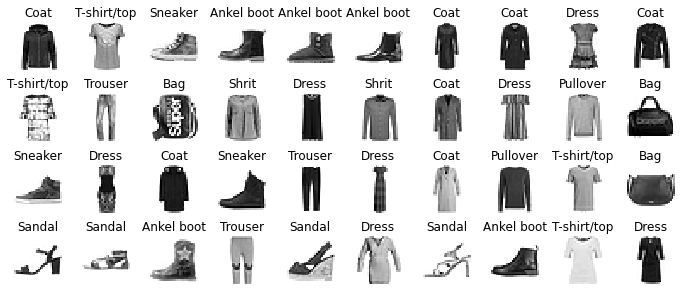

In [20]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

시퀀셜 API를 사용하여 모델 만들기

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [22]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [23]:
model.layers

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [25]:
hidden1 = model.layers[1]
hidden1.name

'dense_3'

In [27]:
model.get_layer('dense_3') is hidden1

True

In [28]:
weights, biases = hidden1.get_weights()
weights

array([[-0.00690497,  0.06151846, -0.05574186, ...,  0.03057632,
        -0.06020389, -0.0656796 ],
       [ 0.02022599,  0.0409288 , -0.03795534, ..., -0.00027327,
         0.03395531, -0.05896407],
       [-0.00147341, -0.05137172, -0.03992692, ...,  0.04026718,
        -0.00254866,  0.02238756],
       ...,
       [ 0.04499762,  0.03050773, -0.05540137, ...,  0.06227136,
        -0.03059097, -0.00734234],
       [-0.02451033, -0.03113247,  0.01298436, ...,  0.06149049,
         0.05992775, -0.02133454],
       [ 0.02085459, -0.00077259,  0.04811689, ...,  0.05325232,
         0.03536591,  0.04685887]], dtype=float32)

In [29]:
weights.shape

(784, 300)

In [30]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [31]:
biases.shape

(300,)

모델 컴파일

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])


#model.compile(loss=keras.losses.sparse_categorical_crossentropy,              
#              optimizer=keras.optimizers.SGD(),
#             metrics=[keras.metrics.sparse_categorical_accuracy])

레이블이 정수 하나로 이루어져 있고 (즉, 샘플마다 타깃 클래스 인덱스가 하나 있습니다. 여기에서는 0에서 9까지의 정수입니다.)\
클래스가 배타적이므로 "sparse_categorical_crossentropy" 손실을 사용한다.\
만약 샘플마다 클래스별 타깃 확률을 가지고 있다면(원-핫벡터라면) "categorical_crossentropy" 손실을 사용합니다.\
이진 분류나 다중 레이블 이진 분류를 수행한다면 출력층에 "softmax" 함수 대신 "sigmoid" 함수를 사용하고 "binary_crossentropy" 손실을 사용

모델 훈련 평가

In [33]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data = (X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7198 - accuracy: 0.7612 - val_loss: 0.5043 - val_accuracy: 0.8340
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4924 - accuracy: 0.8297 - val_loss: 0.4394 - val_accuracy: 0.8498
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4448 - accuracy: 0.8455 - val_loss: 0.4445 - val_accuracy: 0.8534
Epoch 4/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4171 - accuracy: 0.8542 - val_loss: 0.3911 - val_accuracy: 0.8682
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3966 - accuracy: 0.8618 - val_loss: 0.3925 - val_accuracy: 0.8658
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3784 - accuracy: 0.8669 - val_loss: 0.4098 - val_accuracy: 0.8544
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3649 - accuracy: 0.8714 - val_loss: 0.3557 - val_accuracy:

In [34]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [35]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

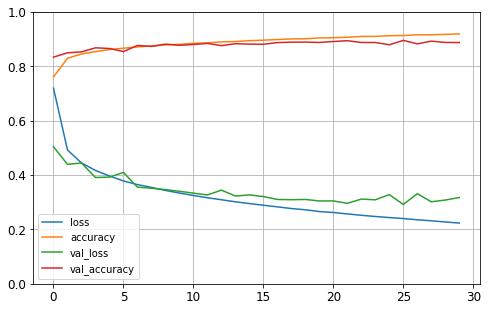

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [38]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.3498 - accuracy: 0.8776


[0.3497987985610962, 0.8776000142097473]

모델을 사용해 예측을 만들기

In [39]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

각 샘플에 대해 0에서 9까지 클래스마다 각각의 확률 모델이 추정했습니다.\
예를 들어 첫 번째 이미지에 대해서는 클래스 9(앵클부츠)의 확률 96%, 클래스 5(샌들)의 확률 3%, 클래스 7(스니커즈)의 확률을 1%

In [40]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [41]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

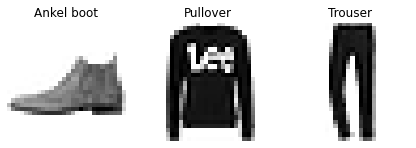

In [42]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

### 10.2.3 시퀀셜 API를 사용하여 회귀용 다층 퍼셉트론 만들기

In [43]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full,y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error",optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7294 - val_loss: 15.9921
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6180 - val_loss: 9.6009
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5292 - val_loss: 0.4534
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3957 - val_loss: 0.3639
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3849 - val_loss: 0.3605
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3776 - val_loss: 0.3825
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3765 - val_loss: 0.3767
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.3689 - val_loss: 0.3864
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3649 - val_loss: 0.4068
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3633 - val_loss: 0.381

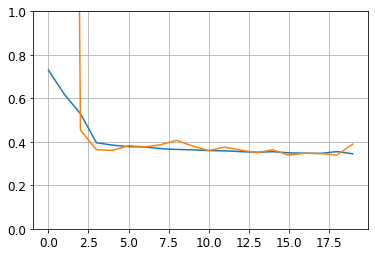

In [46]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [47]:
y_pred

array([[0.71222204],
       [1.668096  ],
       [4.1280465 ]], dtype=float32)

### 10.2.4 함수형 API를 사용해 복잡한 모델 만들기
순차적이지 않은 신경망의 한 예는 와이드 & 딥 신경망입니다. 이 신경망은 입력의 일부 또는 전체가 출력층에 바로 연결됩니다.

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation = "relu")(input_)
hidden2 = keras.layers.Dense(30, activation = "relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 30)           930         ['dense_8[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_9[0][0]']            

In [51]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4659 - val_loss: 0.4313

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [54]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                   validation_data=((X_valid_A,  X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A,X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20


C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


363/363 [==============================] - 1s 2ms/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4644 - val_loss: 0.4315
Epoch 11/2

규제를 위한 보조 출력 추가하기

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [57]:
model.compile(loss=["mse","mse"], loss_weights=[0.9,0.1], optimizer="sgd")

In [58]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                   validation_data = ([X_valid_A, X_valid_B], [y_valid,y_valid]))

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 0.8602 - main_output_loss: 0.7458 - aux_output_loss: 1.8899 - val_loss: 5.9702 - val_main_output_loss: 6.3391 - val_aux_output_loss: 2.6507
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5736 - main_output_loss: 0.5210 - aux_output_loss: 1.0469 - val_loss: 1.4693 - val_main_output_loss: 1.3954 - val_aux_output_loss: 2.1342
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5078 - main_output_loss: 0.4649 - aux_output_loss: 0.8936 - val_loss: 1.8651 - val_main_output_loss: 1.9608 - val_aux_output_loss: 1.0039
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4619 - main_output_loss: 0.4275 - aux_output_loss: 0.7711 - val_loss: 0.4492 - val_main_output_loss: 0.4084 - val_aux_output_loss: 0.8163
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4417 - main_output_loss: 0.4131 - aux_output_loss: 0.6997 - val_loss

In [59]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test,y_test])

162/162 [==============================] - 0s 2ms/step - loss: 0.3609 - main_output_loss: 0.3481 - aux_output_loss: 0.4757


In [60]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

### 10.2.5 서브클래싱 API로 동적 모델 만들기

In [61]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # 표준 매개변수를 처리합니다. (예를 들면, name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.Concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

### 10.2.6 모델 저장과 복원

In [62]:
np.random.seed(42)
tf.random.set_seed(42)

In [63]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [64]:
model.compile(loss="mse", optimizer = keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4382


In [65]:
model.save("my_keras_model.h5")

In [66]:
model = keras.models.load_model("my_keras_model.h5")

In [67]:
model.predict(X_new)

array([[0.5400236],
       [1.6505971],
       [3.0098243]], dtype=float32)

In [68]:
model.save_weights("my_keras_weights.ckpt")

In [69]:
model.load_weights("my_keras_weights.ckpt")

### 10.2.7 콜백 사용하기

In [70]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [72]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "relu", input_shape=[8]),
    keras.layers.Dense(30, activation = "relu"),
    keras.layers.Dense(1)
])

In [75]:
model.compile(loss = "mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data = (X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5")
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.3951


조기 종료 EarlyStopping

In [78]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3230 - val_loss: 0.3105
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3226 - val_loss: 0.3589
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3225 - val_loss: 0.3119
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3223 - val_loss: 0.3102
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3219 - val_loss: 0.3236
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3216 - val_loss: 0.3115
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3212 - val_loss: 0.3106
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3210 - val_loss: 0.3127
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3208 - val_loss: 0.3308
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3204 - val_lo

사용자 정의 callback

In [79]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,spoch,logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [82]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                   validation_data=(X_valid, y_valid),
                   callbacks=[val_train_ratio_cb])

354/363 [============================>.] - ETA: 0s - loss: 0.3163
val/train: 1.05
363/363 [==============================] - 1s 2ms/step - loss: 0.3177 - val_loss: 0.3336


### 10.2.8 텐서보드를 사용해 시각화하기

In [83]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

In [84]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2022_04_19-13_57_54'

In [86]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [88]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [92]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid),
                   callbacks=[tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4474 - val_loss: 0.4379

In [93]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

In [94]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2022_04_19-14_08_13'

In [96]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [98]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [99]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5765 - val_loss: 4.8654
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5506 - val_loss: 2.4561
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4120 - val_loss: 0.3365
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3650 - val_loss: 0.3776
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3574 - val_loss: 0.3306
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3441 - val_loss: 0.3182
Epoch 7/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3386 - val_loss: 0.3191
Epoch 8/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3321 - val_loss: 0.3063
Epoch 9/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3247 - val_loss: 0.2994
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.3210 - val_loss: 0.3152

사용할 수 있는 로깅 옵션

In [100]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=0, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



## 10.3 신경망 하이퍼파라미터 튜닝하기

In [101]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [102]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.SGD(lr=learning_rate)
        model.compile(loss="mse",optimizer=optimizer)
        return model

In [103]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\user0216\AppData\Local\Temp\ipykernel_13044\1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [104]:
keras_reg.fit(X_train, y_train, epochs=100,
             validation_data=(X_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


363/363 [==============================] - 1s 2ms/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4060 - val_loss: 0.4071


In [105]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3412


In [106]:
y_pred = keras_reg.predict(X_new)

In [107]:
np.random.seed(42)
tf.random.set_seed(42)

In [110]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden" : [0,1,2,3],
    "n_neurons" : np.arange(1,100),
    "learning_rate" : reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                 validation_data=(X_valid, y_valid),
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15; total time=   0.0s
[CV] END learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15; total time=   0.0s
[CV] END learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15; total time=   0.0s
[CV] END learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21; total time=   0.0s
[CV] END learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21; total time=   0.0s
[CV] END learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21; total time=   0.0s
Epoch 1/100


C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 2.4034 - val_loss: 2.5263
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.0814 - val_loss: 1.2623
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8276 - val_loss: 0.8816
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7599 - val_loss: 0.7697
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7276 - val_loss: 0.7264
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7032 - val_loss: 0.6893
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6821 - val_loss: 0.6642
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6634 - val_loss: 0.6462
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6455 - val_loss: 0.6364
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6285 - val_loss: 0.6110
E

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 2.3602 - val_loss: 7.3705
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.0191 - val_loss: 7.7410
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8379 - val_loss: 6.4789
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7903 - val_loss: 5.1624
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7611 - val_loss: 4.1122
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7377 - val_loss: 3.3336
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7169 - val_loss: 2.7008
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6977 - val_loss: 2.1841
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6798 - val_loss: 1.7901
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6630 - val_loss: 1.4617
E

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 2.8209 - val_loss: 2.9498
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.1420 - val_loss: 1.3825
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7826 - val_loss: 0.8197
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6903 - val_loss: 0.6636
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6555 - val_loss: 0.6420
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6339 - val_loss: 0.6071
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6163 - val_loss: 0.5892
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6004 - val_loss: 0.5667
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5871 - val_loss: 0.5598
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5739 - val_loss: 0.5616
E

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 3.4392 - val_loss: 10.0874
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.7183 - val_loss: 5.1750
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 1.1387 - val_loss: 2.7655
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9176 - val_loss: 1.7915
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8279 - val_loss: 1.2777
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7831 - val_loss: 0.9864
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7560 - val_loss: 0.8222
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7370 - val_loss: 0.7420
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7222 - val_loss: 0.7003
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7097 - val_loss: 0.6750


C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 4.3730 - val_loss: 10.5001
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.9213 - val_loss: 11.3955
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 1.2367 - val_loss: 11.2470
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9735 - val_loss: 10.5563
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8475 - val_loss: 9.6907
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7786 - val_loss: 8.8280
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7368 - val_loss: 8.0304
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7087 - val_loss: 7.2791
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6874 - val_loss: 6.6309
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6700 - val_loss: 6.02

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 3.1571 - val_loss: 4.3141
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 1.5307 - val_loss: 2.6436
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 1.1111 - val_loss: 1.5511
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9681 - val_loss: 1.1074
Epoch 5/100
242/242 [==============================] - 1s 2ms/step - loss: 0.9018 - val_loss: 0.9874
Epoch 6/100
242/242 [==============================] - 1s 2ms/step - loss: 0.8604 - val_loss: 0.8841
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8293 - val_loss: 0.8288
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8038 - val_loss: 0.7690
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7832 - val_loss: 0.7597
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7644 - val_loss: 0.7679
E

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 1.1279 - val_loss: 13.8175
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6870 - val_loss: 38.2020
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7837 - val_loss: 6.6534
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5142 - val_loss: 3.0277
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4606 - val_loss: 0.4714
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4224 - val_loss: 0.4373
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4142 - val_loss: 0.4055
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4065 - val_loss: 0.4162
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4013 - val_loss: 0.4056
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3975 - val_loss: 0.4046

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 0.8483 - val_loss: 0.5680
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5272 - val_loss: 0.9695
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4592 - val_loss: 0.5027
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4337 - val_loss: 0.4080
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4173 - val_loss: 0.3939
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4058 - val_loss: 0.6644
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3990 - val_loss: 0.8887
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3915 - val_loss: 0.8989
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3876 - val_loss: 1.1776
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3841 - val_loss: 0.6266
E

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 3ms/step - loss: 0.9715 - val_loss: 3.3613
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 0.5493 - val_loss: 25.9594
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5658 - val_loss: 39.6139
Epoch 4/100
242/242 [==============================] - 1s 2ms/step - loss: 1.0167 - val_loss: 0.4254
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4531 - val_loss: 0.3979
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4163 - val_loss: 0.3814
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4084 - val_loss: 0.3711
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3992 - val_loss: 0.3650
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3911 - val_loss: 0.3615
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3880 - val_loss: 0.3590

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 4.7604 - val_loss: 6.2713
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 2.4834 - val_loss: 2.5418
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 1.6189 - val_loss: 1.5325
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 1.2402 - val_loss: 1.2057
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 1.0522 - val_loss: 1.0870
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9460 - val_loss: 1.0392
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8803 - val_loss: 1.0132
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8368 - val_loss: 1.0037
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8065 - val_loss: 0.9691
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7828 - val_loss: 0.9516
E

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 4.1941 - val_loss: 20.7783
Epoch 2/100
242/242 [==============================] - 1s 2ms/step - loss: 2.6290 - val_loss: 25.1501
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 1.8244 - val_loss: 26.2267
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 1.3812 - val_loss: 25.2779
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 1.1332 - val_loss: 23.0732
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9923 - val_loss: 20.5882
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9084 - val_loss: 18.1375
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8553 - val_loss: 15.7943
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8189 - val_loss: 13.7368
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7914 - val_loss:

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 5.4197 - val_loss: 12.8701
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 3.0784 - val_loss: 7.7573
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 2.0250 - val_loss: 3.9145
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 1.5062 - val_loss: 2.1514
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 1.2447 - val_loss: 1.3019
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 1.1027 - val_loss: 1.0174
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 1.0172 - val_loss: 0.9447
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9605 - val_loss: 0.9578
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9198 - val_loss: 0.9473
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8874 - val_loss: 0.9098


C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 1.5732 - val_loss: 28.9001
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9106 - val_loss: 0.6043
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5666 - val_loss: 0.5264
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5130 - val_loss: 0.4771
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4761 - val_loss: 0.4447
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4514 - val_loss: 0.4269
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4344 - val_loss: 0.4104
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4213 - val_loss: 0.4002
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4137 - val_loss: 0.3980
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4082 - val_loss: 0.3894


C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 1.4268 - val_loss: 14.9055
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6792 - val_loss: 1.9920
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5582 - val_loss: 0.5848
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4953 - val_loss: 0.5158
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4629 - val_loss: 0.6963
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4447 - val_loss: 0.7083
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4345 - val_loss: 0.6351
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4254 - val_loss: 0.6128
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4194 - val_loss: 0.4788
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4169 - val_loss: 0.4463


C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 1.3892 - val_loss: 18.0002
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7751 - val_loss: 39.2206
Epoch 3/100
242/242 [==============================] - 1s 2ms/step - loss: 0.7896 - val_loss: 0.5994
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4746 - val_loss: 0.5045
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4500 - val_loss: 0.4594
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4372 - val_loss: 0.4293
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4283 - val_loss: 0.4100
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4217 - val_loss: 0.3970
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4156 - val_loss: 0.3891
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4131 - val_loss: 0.3832

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 1.8985 - val_loss: 11.5391
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8431 - val_loss: 13.8369
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.7138 - val_loss: 1.3753
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5324 - val_loss: 0.4790
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4871 - val_loss: 0.4393
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4633 - val_loss: 0.4240
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4478 - val_loss: 0.4097
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4366 - val_loss: 0.4128
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4290 - val_loss: 0.4126
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4234 - val_loss: 0.4114

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 1.2531 - val_loss: 8.4055
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6670 - val_loss: 1.7780
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5778 - val_loss: 0.5257
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5209 - val_loss: 1.0604
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4829 - val_loss: 1.9031
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4601 - val_loss: 2.3185
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4456 - val_loss: 2.4536
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4348 - val_loss: 2.3708
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4263 - val_loss: 1.9596
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4206 - val_loss: 1.5661
E

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 1.7074 - val_loss: 6.6189
Epoch 2/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6725 - val_loss: 16.1985
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6227 - val_loss: 23.9020
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8397 - val_loss: 17.3449
Epoch 5/100
242/242 [==============================] - 0s 2ms/step - loss: 0.6182 - val_loss: 0.6318
Epoch 6/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4636 - val_loss: 0.4187
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4438 - val_loss: 0.4140
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4357 - val_loss: 0.4050
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4291 - val_loss: 0.4250
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4253 - val_loss: 0.408

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\wrappers\scikit_learn.py", line 157, in fit
    if (losses.is_categorical_crossentropy(self.model.loss) and
AttributeError: 'NoneType' object has no attribute 'loss'

  warnings.warn(some_fits_failed_message, Fi

363/363 [==============================] - 1s 2ms/step - loss: 0.8132 - val_loss: 10.1505
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5948 - val_loss: 13.7267
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.5774 - val_loss: 3.3477
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4243 - val_loss: 4.7178
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4225 - val_loss: 6.3752
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4447 - val_loss: 0.5646
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3919 - val_loss: 0.4474
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3812 - val_loss: 0.4239
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3763 - val_loss: 0.4123
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3744 - val_loss: 0.3936

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000021505C6D4E0>,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021505C83910>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   verbose=2)

In [111]:
rnd_search_cv.best_params_

{'learning_rate': 0.008339092654580042, 'n_hidden': 1, 'n_neurons': 38}

In [112]:
rnd_search_cv.best_score_

-0.3645240863164266

In [114]:
model = rnd_search_cv.best_estimator_.model
model

In [115]:
model.evaluate(X_test,y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3163


0.3163363039493561